In [1]:
import tensorflow as tf 
import random, numpy as np, os
import tensorflow_datasets as tfds

def accelerate_gpu(mp=False):
    AUTO = tf.data.AUTOTUNE
    print(tf.executing_eagerly())
    print('A: ', tf.test.is_built_with_cuda)
    print('B: ', tf.test.gpu_device_name())
    
    GPUS = tf.config.list_physical_devices('GPU')
    if GPUS:
        try:
            for GPU in GPUS:
                tf.config.experimental.set_memory_growth(GPU, True)
                logical_gpus = tf.config.list_logical_devices('GPU')
                print(len(GPUS), "Physical GPUs,", len(logical_gpus), "Logical GPUs") 
        except RuntimeError as  RE:
            print(RE)
    if mp:
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        print('Mixed precision enabled')
        
def seed_all(s):
    random.seed(s)
    np.random.seed(s)
    tf.random.set_seed(s)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['PYTHONHASHSEED'] = str(s)    
        
accelerate_gpu(False)

True
A:  <function is_built_with_cuda at 0x7fae12059680>
B:  /device:GPU:0
1 Physical GPUs, 1 Logical GPUs


## TF Dataset and Preprocess

In [2]:
BATCH_SIZE  = 12
IMG_SIZE    = 256
CHANNELS    = 3
EPOCHS = 10
LR = 0.002

In [3]:
tfds.disable_progress_bar()
data, ds_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
train_ds, valid_ds, test_ds = data['train'], data['validation'], data['test']

for i, data in enumerate(train_ds.take(3)):
    print(i+1, data[0].shape, data[1])
    
NUM_CLASSES = ds_info.features["label"].num_classes
NUM_CLASSES

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete0ZPMBE/oxford_flowers102-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete0ZPMBE/oxford_flowers102-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete0ZPMBE/oxford_flowers102-validation.tfrecord
Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
1 (500, 667, 3) tf.Tensor(72, shape=(), dtype=int64)
2 (500, 666, 3) tf.Tensor(84, shape=(), dtype=int64)
3 (670, 500, 3) tf.Tensor(70, shape=(), dtype=int64)


102

In [4]:
# pre-process functions 
def normalize_resize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    label = tf.one_hot(label , depth=NUM_CLASSES) 
    return image, label

# augmentation 
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    return image, label 


train = train_ds.map(normalize_resize).map(augment).shuffle(1024).batch(BATCH_SIZE).repeat()
valid = valid_ds.map(normalize_resize).batch(BATCH_SIZE)
test  = test_ds.map(normalize_resize).batch(BATCH_SIZE)

## Sample Viz

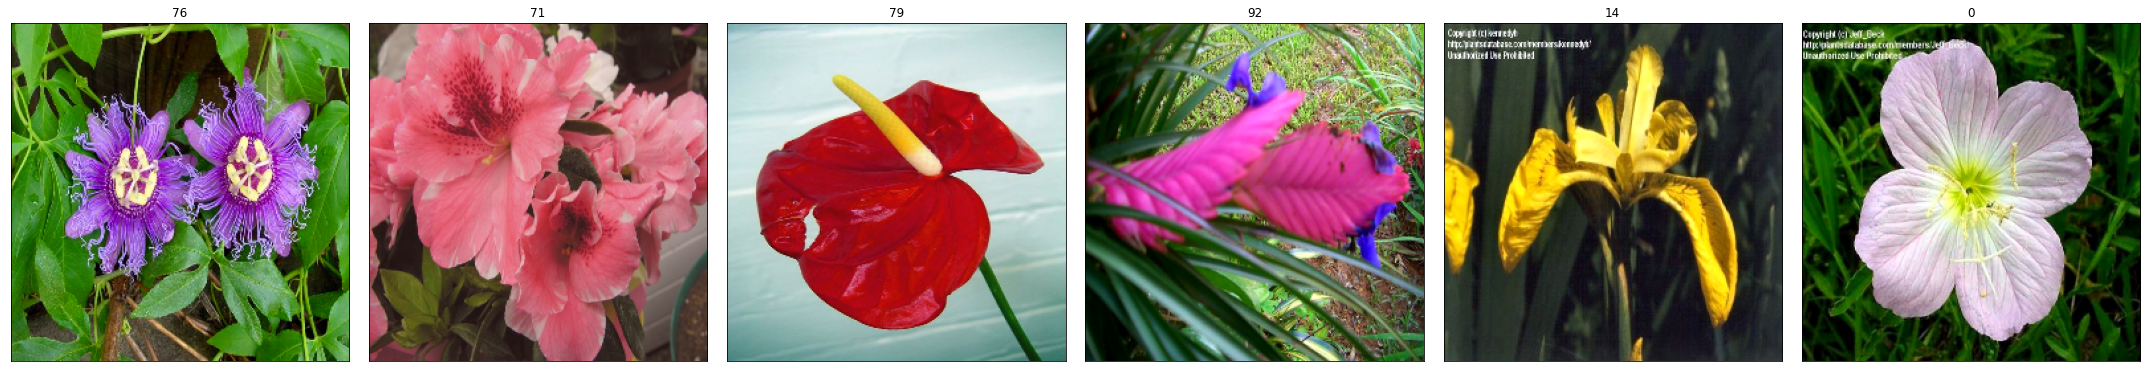

In [5]:
import matplotlib.pyplot as plt 

def display_batch(batch, size=10):
    imgs, tars = next(iter(batch))
    plt.figure(figsize=(size*5, 5))
    
    for img_idx in range(size):
        plt.subplot(1, size, img_idx+1)
        plt.title(tf.argmax(tars[img_idx]).numpy())
        plt.imshow(imgs[img_idx] / 255)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show() 
    
display_batch(batch=train, size=int(BATCH_SIZE // 2))

# DOLG-EfficientNetB5 

[Details.](https://mp.weixin.qq.com/s/7B3hZUpLtTt8NcGt0c-77w) 

![](https://user-images.githubusercontent.com/17668390/138777383-b1d475d7-c842-4577-8554-30cf2013cadc.png)

**Local Branch**

In [6]:
import tensorflow as tf 
from tensorflow.keras import (layers, Sequential, activations, initializers)

# Multi-Atrous Branch
class MultiAtrous(tf.keras.Model):
    def __init__(self, dilation_rates=[6, 12, 18], upsampling=1, 
                 kernel_size=3, padding="same",  **kwargs):
        super(MultiAtrous, self).__init__(name='MultiAtrous', **kwargs)
        self.dilation_rates = dilation_rates
        self.kernel_size = kernel_size 
        self.upsampling = upsampling
        self.padding = padding
      
        # Dilated Convolutions                     
        self.dilated_convs = [
                                layers.Conv2D(
                                    filters       = int(1024 / 4), 
                                    kernel_size   = self.kernel_size,  
                                    padding       = self.padding, 
                                    dilation_rate = rate
                                ) for rate in self.dilation_rates
                             ]
        
        # Global Average Pooling Branch 
        self.gap_branch = Sequential(
            [
                layers.GlobalAveragePooling2D(keepdims=True),
                layers.Conv2D(int(1024 / 2), kernel_size=1),
                layers.Activation('relu'),
                layers.UpSampling2D(size=self.upsampling, interpolation="bilinear")
            ] , name='gap_branch'
        )
        
    def call(self, inputs, training=None, **kwargs):
        local_feature = []

        for dilated_conv in self.dilated_convs:
            x = dilated_conv(inputs) 
            x = self.gap_branch(x)
            local_feature.append(x)
            
        return tf.concat(local_feature, axis=-1)

    def get_config(self):
        config = {
            'dilation_rates': self.dilation_rates,
            'kernel_size'   : self.kernel_size,
            'padding'       : self.padding,
            'upsampling'    : self.upsampling
        }
        base_config = super(MultiAtrous, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    
# DOLG: Local-Branch
class DOLGLocalBranch(tf.keras.Model):
    def __init__(self, **kwargs):
        super(DOLGLocalBranch, self).__init__(name='LocalBranch', **kwargs)
        self.multi_atrous = MultiAtrous(padding='same', upsampling=int(IMG_SIZE/32))

        self.conv1 = layers.Conv2D(1024, kernel_size=1)
        self.conv2 = layers.Conv2D(1024, kernel_size=1, use_bias=False)
        self.conv3 = layers.Conv2D(1024, kernel_size=1)
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=None, **kwargs):
        # Local Branach + Normalization / Conv-Bn Module 
        local_feat = self.multi_atrous(inputs)
        local_feat = self.conv1(local_feat)
        local_feat = tf.nn.relu(local_feat)
        
        # Self-Attention
        local_feat = self.conv2(local_feat)
        local_feat = self.bn(local_feat)

        # l-2 norms
        norm_local_feat = tf.math.l2_normalize(local_feat)

        # softplus activations
        attn_map = tf.nn.relu(local_feat)
        attn_map = self.conv3(attn_map)
        attn_map = activations.softplus(attn_map) 

        # Output of the Local-Branch 
        return  norm_local_feat * attn_map 

**Orthogonal Fusion**

In [7]:
import tensorflow as tf 
from tensorflow.keras import layers 

class OrthogonalFusion(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(name='OrthogonalFusion', **kwargs)
    def call(self, inputs):
        local_feat, global_feat = inputs
        height = local_feat.shape[1]
        width  = local_feat.shape[2]
        depth  = local_feat.shape[3]
    
        local_feat = tf.reshape(local_feat, [-1, height*width, depth])
        local_feat = tf.transpose(local_feat, perm=[0, 2, 1])
        
        projection = tf.matmul(
            tf.expand_dims(global_feat, axis=1), 
            local_feat
        )
        projection = tf.matmul(
            tf.expand_dims(global_feat, axis=2),
            projection
        )
        projection = tf.reshape(projection, [-1, height, width, depth])
        
        global_feat_norm = tf.norm(global_feat, ord=2, axis=1)  
        projection = projection / tf.reshape(global_feat_norm*global_feat_norm, shape=[-1, 1, 1, 1])
        local_feat = tf.transpose(local_feat, perm=[0, 1, 2])
        local_feat = tf.reshape(local_feat, [-1, height, width, depth])
    
        orthogonal_comp = local_feat - projection
        global_feat = tf.expand_dims(tf.expand_dims(global_feat, axis=1), axis=1)
        global_feat = tf.broadcast_to(global_feat, tf.shape(local_feat))
        output = tf.concat([global_feat, orthogonal_comp], axis=-1)
        return output

**Generalized Mean Pooling**

In [8]:
class GeneralizedMeanPooling2D(layers.Layer):
    def __init__(self, init_norm=3.0, normalize=False, epsilon=1e-6, **kwargs):
        self.init_norm = init_norm
        self.normalize = normalize
        self.epsilon   = epsilon
        super(GeneralizedMeanPooling2D, self).__init__(name='GeM', **kwargs)

    def build(self, input_shape):
        self.p = self.add_weight(name="norms", 
                                 shape=(input_shape[-1],),
                                 initializer=initializers.constant(self.init_norm),
                                 trainable=True)
        super(GeneralizedMeanPooling2D, self).build(input_shape)

    def call(self, inputs):
        x = tf.reduce_mean(tf.abs(inputs**self.p), axis=[1,2], keepdims=False) + self.epsilon
        x = x**(1.0 / self.p)
        if self.normalize:
            x = tf.nn.l2_normalize(x, 1)
        return x

    def get_config(self):
        config = {
            'init_norm' : self.init_norm,
            'normalize' : self.normalize,
            'epsilon'   : self.epsilon
        }
        base_config = super(GeneralizedMeanPooling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

**DOLG-EfficientNetB5**

In [9]:
from tensorflow.keras import applications, layers, Model, Input

class DOLGNet(tf.keras.Model):
    def __init__(self, Classifier, **kwargs):
        super(DOLGNet, self).__init__(name='DOLGNet', **kwargs)
        # Number of classes 
        self.Classifier = Classifier
        
        # Top building blocks 
        self.orthogonal_fusion = OrthogonalFusion()
        self.local_branch      = DOLGLocalBranch()
   
        # Tail blcok 1 
        self.glob_branch_pool = Sequential([
            # GeneralizedMeanPooling2D(), < --- issue: cause nan loss - todo: fix
            layers.GlobalAveragePooling2D(),
            layers.Dense(1024, activation=None)
        ], name='GlobalBranchPooling')
        
        # Base blcoks 
        base = applications.EfficientNetB5(
            include_top=False,
            weights='imagenet',
            input_tensor=Input((IMG_SIZE, IMG_SIZE, 3))
        )
        self.new_base = Model(
            [base.inputs], 
            [
                base.get_layer('block5g_add').output,  # fol local branch 
                base.get_layer('block7c_add').output   # for global branch 
             ], 
            name='EfficientNet'
        )
        
        # Head block
        if Classifier == 1:
            self.classifier = Sequential([
                layers.GlobalAveragePooling2D(name='HeadGAP'),
                layers.Dense(1, activation = 'sigmoid')
            ], name='Classifiers')

        else:
            self.classifier = Sequential([
                layers.GlobalAveragePooling2D(name='HeadGAP'),
                layers.Dense(Classifier, activation = 'softmax')
            ], name='Classifiers')
    
            
    # forwarding the computation 
    def call(self, inputs, training=None, **kwargs):
        # Get tensor from target layers 
        to_local, to_global = self.new_base(inputs)

        # Pass the received tensor to Top building blocks 
        local_feat      = self.local_branch(to_local)
        global_feat     = self.glob_branch_pool(to_global)
        orthogonal_feat = self.orthogonal_fusion([local_feat, global_feat]) 
        
        if training:
            return self.classifier(orthogonal_feat)
        else:
            return self.classifier(orthogonal_feat), orthogonal_feat

    def build_graph(self):
        x = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        return Model(inputs=[x], outputs=self.call(x))

**Build and Display**

115277824/115263384 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
EfficientNet (Functional)       [(None, 16, 16, 176) 27456759    input_2[0][0]                    
__________________________________________________________________________________________________
LocalBranch (DOLGLocalBranch)   (None, 8, 8, 1024)   5025024     EfficientNet[0][0]               
__________________________________________________________________________________________________
GlobalBranchPooling (Sequential (None, 1024)         525312      EfficientNet[0][1]               
___________________________

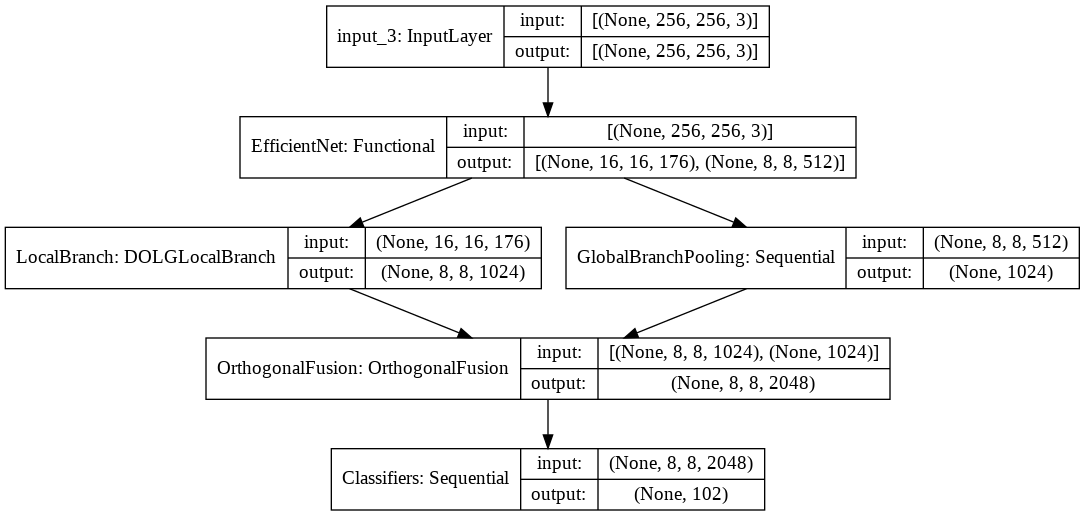

In [10]:
model = DOLGNet(Classifier=NUM_CLASSES)

_ = model(tf.ones((1, IMG_SIZE, IMG_SIZE, CHANNELS)))[0]
print(model.build_graph().summary())
display(tf.keras.utils.plot_model(model.build_graph(), 
                                  show_shapes=True, 
                                  show_layer_names=True,
                                  expand_nested=False))

In [11]:
from tensorflow.keras import optimizers, metrics, losses

model.compile(
    optimizer=optimizers.Adam(learning_rate=LR),
    loss=losses.CategoricalCrossentropy(),
    metrics=[
        metrics.TopKCategoricalAccuracy(k=3, name='acc_top3'),
        metrics.TopKCategoricalAccuracy(k=1, name='acc_top1')
    ])

model.fit(train, 
          steps_per_epoch=len(train_ds) // BATCH_SIZE,  
          epochs=EPOCHS, validation_data=valid, verbose=1)

Epoch 1/10
85/85 [==============================] - 155s 1s/step - loss: 4.7577 - acc_top3: 0.2441 - acc_top1: 0.1225 - val_loss: 13.7294 - val_acc_top3: 0.1922 - val_acc_top1: 0.0892
Epoch 2/10
85/85 [==============================] - 119s 1s/step - loss: 2.3646 - acc_top3: 0.6461 - acc_top1: 0.4265 - val_loss: 6.6224 - val_acc_top3: 0.4353 - val_acc_top1: 0.2471
Epoch 3/10
85/85 [==============================] - 119s 1s/step - loss: 1.7528 - acc_top3: 0.7588 - acc_top1: 0.5716 - val_loss: 6.2450 - val_acc_top3: 0.3725 - val_acc_top1: 0.2059
Epoch 4/10
85/85 [==============================] - 119s 1s/step - loss: 1.2760 - acc_top3: 0.8412 - acc_top1: 0.6647 - val_loss: 7.7394 - val_acc_top3: 0.4108 - val_acc_top1: 0.2520
Epoch 5/10
85/85 [==============================] - 119s 1s/step - loss: 1.0388 - acc_top3: 0.8941 - acc_top1: 0.7225 - val_loss: 9.1296 - val_acc_top3: 0.4098 - val_acc_top1: 0.2657
Epoch 6/10
85/85 [==============================] - 119s 1s/step - loss: 0.8377 - ac